In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import ivac
import pyemma
import sys

In [2]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

In [4]:
# use feature 2, based on what looked best for Rong's MSM
data_trajs = np.load("../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
print(len(data_trajs), data_trajs[0].shape)

237 (10000, 60)


In [5]:
import pickle

In [6]:
# TICA/IVAC to reduce dimensionality
with open("../data/livac-feat2-anton.pkl", mode="rb") as f:
    livac = pickle.load(f)

plot eigenvalues squared to decide on spectral gap: kinetic variance
$$\mathrm{KV_m} = \frac{\sum_{i=1}^m\lambda_i^2}{TKV}$$

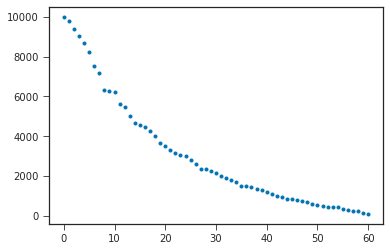

In [8]:
evals = livac.evals
plt.plot(evals, ".")

In [7]:
# definitely appears to be a gap near 7 or 10 eigenvalues
# take the top 10 eigenvectors
ivac_trajs = np.load("../data/feat2_anton_ivac.npy", allow_pickle=True)
print(len(ivac_trajs), ivac_trajs[0].shape)

237 (10000, 10)


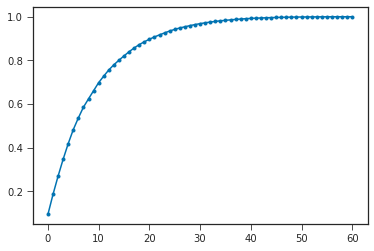

In [12]:
kv = np.cumsum(evals ** 2) / np.sum(evals ** 2)
plt.plot(kv, ".-")

In [13]:
# cluster, use 500 clusters
ivac_arr = np.concatenate(ivac_trajs)
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=ivac_arr, k=500, max_iter=100, n_jobs=32
)

01-07-21 09:59:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 17 steps.


In [14]:
dtrajs = km.dtrajs[0]

In [15]:
dtrajs.shape

(3000000,)

In [17]:
np.save("../data/raw_feat/feat2_ind500_anton.npy", dtrajs)

In [8]:
dtrajs = np.load("../data/raw_feat/feat2_ind500_anton.npy")

In [9]:
# split into individual trajectories
orig_traj_lens = [len(traj) for traj in data_trajs]
orig_traj_inds = []
subtot = 0
for length in orig_traj_lens[:-1]:
    subtot += length
    orig_traj_inds.append(subtot)
dtrajs = np.split(dtrajs, orig_traj_inds)
print(len(dtrajs))

237


In [10]:
len(dtrajs[0])

10000

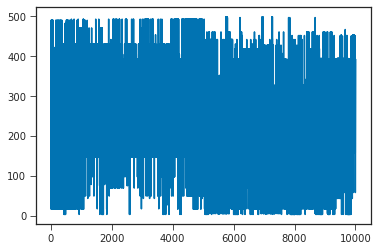

In [23]:
plt.plot(dtrajs[0])

# qMSM construction 

Described in Cao *JCP* 2020 "On the advantages of exploiting memory in Markov state models for biomolecular dynamics "

Discretization of the GLE and transition matrix:
$$\dot{T}(n\Delta t) = \dot{T}(0)T(n\Delta t) + \Delta t \sum_{m=1}^n\mathscr{K}(m\Delta t) T((n-m)\Delta t)$$

where the memory kernel $\mathscr{K}$ satisfies
$$\mathscr{K}(n\Delta t) = \frac{\dot{T}(n\Delta t) - \dot{T}(0)T(n\Delta t)}{\Delta t} - \sum_{m=1}^{n-1}\mathscr{K}(m\Delta t)T((n-m)\Delta t)$$
<br>
We can approximate the derivatives using a first-order forward difference:
$$\dot{T}(n\Delta t) \approx \frac{T((n+1)\Delta t) - T(n\Delta t)}{\Delta t}$$

**Recompute using reversible MSMs so we can perform PCCA** (7.13.21)

In [14]:
# compute the transition matrix at a bunch of time points
models = []
max_lag = 1000  # in number of MD steps (*0.1 ns)
step = 10
nstates = 500
T_list = np.empty((max_lag // 10, nstates, nstates))
for lag in range(1, max_lag + 1, step):
    if lag % 100 == 1:
        print(f"Calculating transition matrices for lag {lag}")
    T = pyemma.msm.estimate_markov_model(dtrajs, lag, reversible=True)
    models.append(T)
    T_list[lag // 10] = T.transition_matrix

Calculating transition matrices for lag 1
Calculating transition matrices for lag 101
Calculating transition matrices for lag 201
Calculating transition matrices for lag 301
Calculating transition matrices for lag 401
Calculating transition matrices for lag 501
Calculating transition matrices for lag 601
Calculating transition matrices for lag 701
Calculating transition matrices for lag 801
Calculating transition matrices for lag 901


In [15]:
len(models)

100

In [16]:
def compute_kernel(T_list):
    # compute the kernel at all time points
    K_list = np.zeros_like(T_list)
    # forward finite difference for derivative
    T_dots = T_list[1:] - T_list[:-1]

    # first element of memory kernel
    # T(0) = 1
    nstates = T_list.shape[1]
    T_dot_0 = T_list[0] - np.eye(nstates)
    K1 = T_dots[0] - T_dot_0 @ T_list[0]
    K_list[0] = K1

    for n in range(1, len(T_list) - 1):
        if n % 100 == 0:
            print(f"Finished computing kernel {n}")
        conv = np.zeros_like(K1)
        for m in range(0, n):
            # K is not defined at time 0
            conv += K_list[m] @ T_list[n - m - 1]
        K = (T_dots[n] - T_dot_0 @ T_list[n]) - conv
        K_list[n] = K

    return K_list

In [42]:
# implied timescales from "vanilla" MSMs
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
its = pyemma.msm.its(dtrajs, lags, reversible=False, n_jobs=16)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:549: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


<AxesSubplot:xlabel='lag time / $\\mu$s', ylabel='timescale / $\\mu$s'>

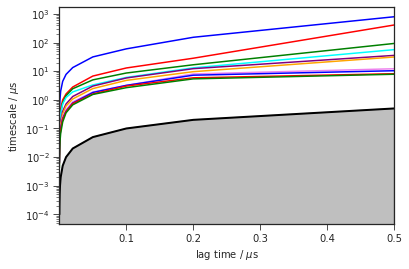

In [44]:
pyemma.plots.plot_implied_timescales(its, nits=10, units="$\mu$s", dt=0.0001)

In [17]:
# implied timescales from "vanilla" MSMs
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
its = pyemma.msm.its(dtrajs, lags, reversible=True)

<AxesSubplot:xlabel='lag time / $\\mu$s', ylabel='timescale / $\\mu$s'>

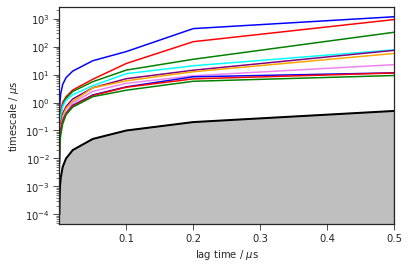

In [18]:
pyemma.plots.plot_implied_timescales(its, nits=10, units="$\mu$s", dt=0.0001)

Note that MSMs don't converge even at lag times of 500 ns

In [14]:
len(T_list)

100

In [19]:
evals = [T.eigenvalues() for T in models]

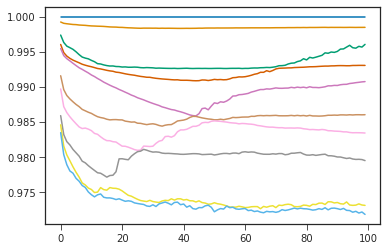

In [20]:
plt.plot(np.asarray(evals)[:, :10])
# maybe a gap after 7 or 2 eigenvalues?

In [25]:
ck = pyemma.msm.ChapmanKolmogorovValidator(T_list[50])

TypeError: __init__() missing 2 required positional arguments: 'test_estimator' and 'memberships'

In [22]:
models[10].cktest(7)

ChapmanKolmogorovValidator(conf=0.95, err_est=False,
              memberships=array([[3.28490e-01, 6.53728e-03, ..., 6.52131e-01, 2.24258e-03],
       [1.80579e-04, 3.22222e-03, ..., 1.12061e-02, 9.76637e-01],
       ...,
       [2.22686e-04, 2.26493e-03, ..., 1.19713e-02, 9.76322e-01],
       [6.56102e-02, 3.66198e-03, ..., 8.02308e-01, 2.93116e-02]]),
              mlags=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), n_jobs=40,
              show_progress=True,
              test_estimator=MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=101, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
              test_model=MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=101, maxerr=1e-08,
           max

In [34]:
T_all = np.asarray([T.transition_matrix for T in T_list])

In [35]:
T_all.shape

(100, 500, 500)

In [46]:
T_list = np.asarray(T_list)
print(T_list.shape)

(1000, 500, 500)


In [36]:
T_dots = T_all[1:] - T_all[:-1]
T_dots.shape

(99, 500, 500)

In [37]:
nstates = T_all.shape[1]
T_dot_0 = T_all[0] - np.eye(nstates)
K1 = T_dots[0] - T_dot_0 @ T_all[0]

In [38]:
K1

array([[ 8.67274887e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.83144951e-02,  0.00000000e+00, ...,
         0.00000000e+00, -4.09925976e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.50444613e-01, ...,
         0.00000000e+00,  0.00000000e+00, -7.03121016e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.55151601e-01,  0.00000000e+00, -2.26221534e-03],
       [ 0.00000000e+00, -4.45315479e-03,  0.00000000e+00, ...,
         0.00000000e+00,  6.86874634e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.43213092e-05, ...,
        -3.31045265e-03,  0.00000000e+00,  1.18016900e-01]])

In [31]:
K_all = compute_kernel(np.asarray([T.transition_matrix for T in T_list]))

In [39]:
K_all[0]

array([[ 8.67274887e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.83144951e-02,  0.00000000e+00, ...,
         0.00000000e+00, -4.09925976e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.50444613e-01, ...,
         0.00000000e+00,  0.00000000e+00, -7.03121016e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.55151601e-01,  0.00000000e+00, -2.26221534e-03],
       [ 0.00000000e+00, -4.45315479e-03,  0.00000000e+00, ...,
         0.00000000e+00,  6.86874634e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.43213092e-05, ...,
        -3.31045265e-03,  0.00000000e+00,  1.18016900e-01]])

In [32]:
K_all[1]

array([[ 6.55089778e-02,  0.00000000e+00,  3.71269297e-09, ...,
         2.88647747e-08,  0.00000000e+00,  5.57547586e-07],
       [ 0.00000000e+00,  3.72948333e-02,  1.66114068e-10, ...,
         9.10341721e-09, -5.55961460e-03,  5.23929710e-09],
       [ 1.65112139e-09,  2.26435387e-10,  8.43207791e-02, ...,
         1.16876306e-07,  2.51399270e-09,  5.08737535e-05],
       ...,
       [ 3.63958784e-09,  1.15760535e-08,  1.28646816e-07, ...,
         9.09596100e-02,  4.18801343e-09, -4.54866788e-04],
       [ 0.00000000e+00, -6.15495494e-03,  4.13663146e-09, ...,
         4.58967084e-09,  4.81346655e-02, -2.31240763e-09],
       [ 1.24797583e-06,  4.79462520e-08,  8.99433010e-05, ...,
        -1.16795170e-03,  1.93858047e-07,  7.24111536e-02]])

In [41]:
conv = np.zeros_like(K1)
conv += K_all[0] @ T_all[0]
K2 = (T_dots[1] - T_dot_0 @ T_all[1]) - K_all[0] @ T_all[0]

In [42]:
K2

array([[ 6.55089778e-02,  0.00000000e+00,  3.71269297e-09, ...,
         2.88647747e-08,  0.00000000e+00,  5.57547586e-07],
       [ 0.00000000e+00,  3.72948333e-02,  1.66114068e-10, ...,
         9.10341721e-09, -5.55961460e-03,  5.23929710e-09],
       [ 1.65112139e-09,  2.26435387e-10,  8.43207791e-02, ...,
         1.16876306e-07,  2.51399270e-09,  5.08737535e-05],
       ...,
       [ 3.63958784e-09,  1.15760535e-08,  1.28646816e-07, ...,
         9.09596100e-02,  4.18801343e-09, -4.54866788e-04],
       [ 0.00000000e+00, -6.15495494e-03,  4.13663146e-09, ...,
         4.58967084e-09,  4.81346655e-02, -2.31240763e-09],
       [ 1.24797583e-06,  4.79462520e-08,  8.99433010e-05, ...,
        -1.16795170e-03,  1.93858047e-07,  7.24111536e-02]])

In [43]:
K3 = (T_dots[2] - T_dot_0 @ T_all[2]) - (K_all[0] @ T_all[1] + K_all[1] @ T_all[0])

In [44]:
K3

array([[ 4.43766429e-02, -1.77723094e-12, -6.96886427e-09, ...,
        -1.59396574e-07, -4.15461793e-12, -2.01100433e-07],
       [-4.49005354e-12,  2.89883534e-02, -2.97567019e-09, ...,
        -1.17098471e-08, -1.24789350e-03, -1.57055038e-08],
       [-2.23527175e-08, -9.82574902e-09,  6.56837734e-02, ...,
        -6.47635741e-07, -1.86465211e-08,  3.56380035e-05],
       ...,
       [-1.91636853e-07, -2.18410119e-08, -7.70888290e-07, ...,
         5.79469294e-02, -2.81310017e-08, -4.67101458e-07],
       [-2.00415856e-11, -1.90752428e-03, -3.63886329e-09, ...,
        -1.79527757e-08,  3.71443010e-02,  1.58537511e-07],
       [-8.08259832e-08, -1.51477234e-07,  4.20220289e-05, ...,
        -1.13786446e-03, -8.82151335e-08,  4.02860049e-02]])

In [45]:
K_all[2]

array([[ 4.43766429e-02, -1.77723094e-12, -6.96886427e-09, ...,
        -1.59396574e-07, -4.15461793e-12, -2.01100433e-07],
       [-4.49005354e-12,  2.89883534e-02, -2.97567019e-09, ...,
        -1.17098471e-08, -1.24789350e-03, -1.57055038e-08],
       [-2.23527175e-08, -9.82574902e-09,  6.56837734e-02, ...,
        -6.47635741e-07, -1.86465211e-08,  3.56380035e-05],
       ...,
       [-1.91636853e-07, -2.18410119e-08, -7.70888290e-07, ...,
         5.79469294e-02, -2.81310017e-08, -4.67101458e-07],
       [-2.00415856e-11, -1.90752428e-03, -3.63886329e-09, ...,
        -1.79527757e-08,  3.71443010e-02,  1.58537511e-07],
       [-8.08259832e-08, -1.51477234e-07,  4.20220289e-05, ...,
        -1.13786446e-03, -8.82151335e-08,  4.02860049e-02]])

# Evaluate kernel decay

Mean integrated kernel defined as:
$$MIK(t) = \frac{1}{N} \sqrt{\sum_{i,j=1}^N\left(\int_0^t\mathrm dt' \mathscr{K}_{ij}(t')\right)^2}$$

In [46]:
def MIK(kernels):
    N = kernels.shape[1]
    running_sum = np.einsum("ijk->i", np.cumsum(kernels, axis=0) ** 2)
    return np.sqrt(running_sum) / N

In [47]:
mik = MIK(K_all)

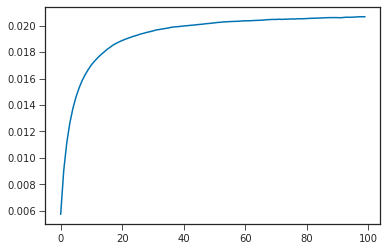

In [48]:
plt.plot(mik)

In [123]:
K_all = compute_kernel(T_list)

Finished computing kernel 100
Finished computing kernel 200
Finished computing kernel 300
Finished computing kernel 400
Finished computing kernel 500
Finished computing kernel 600
Finished computing kernel 700
Finished computing kernel 800
Finished computing kernel 900


In [49]:
K_all.shape

(100, 500, 500)

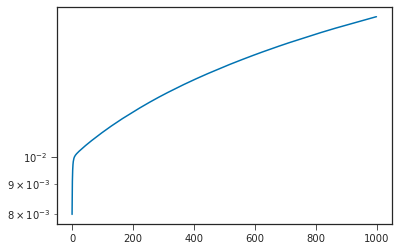

In [129]:
plt.plot(MIK(K_all))
plt.yscale("log")

In [141]:
mik = MIK(K_all)

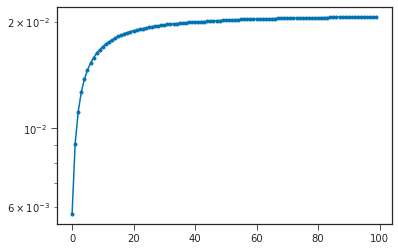

In [54]:
plt.plot(mik, ".-")
plt.yscale("log")

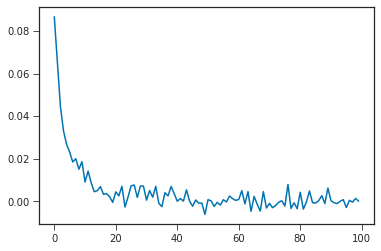

In [50]:
plt.plot(K_all[:, 0, 0])

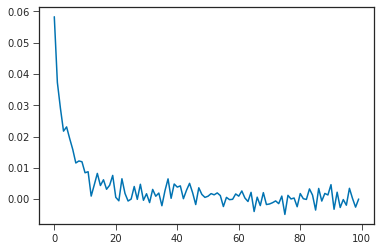

In [104]:
plt.plot(K_all[:, 1, 1])

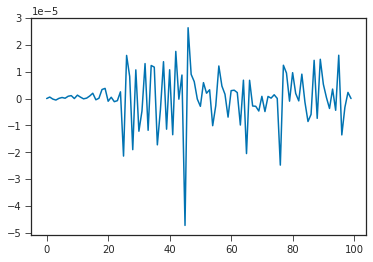

In [51]:
plt.plot(K_all[:, 0, 499])

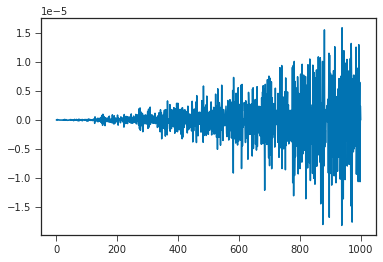

In [135]:
plt.plot(K_all[:, 50, 200])

Where is all the noise coming from? The MIK seems to plateau around 10 steps (1 ns), but then keeps growing at larger time scales
Used incorrect formula for MIK lol

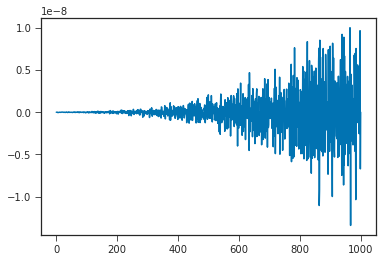

In [139]:
plt.plot(K_all[:, 300, 100])

In [145]:
# MIK plateaus around 300 steps (30 ns)
# save kernels up to 300 steps
np.save("../data/qMSM_kernels_300_feat2", K_all[:300])

# Integrate transition matrix 

GME for transition matrix:
$$\dot{T}(t) = \dot{T}(0)T(t) + \int_0^{\min\{t, \tau_K\}}T(t - \tau)K(\tau)\mathrm d\tau$$
where $\tau_K$ = 30 ns here

In [166]:
def integrate_heun(f, y0, t0, h, nsteps, *args):
    # f is the function to integrate forward which takes the time
    # and the current value of y as arguments
    # y0 is the starting value
    # h is the step size
    # nsteps is number of steps to propagate forward
    #
    # solve the ODE y' = f(t, y) with initial condition (t0, y0)
    y_all = [y0]
    t = t0
    print(args)
    for n in range(nsteps):
        f_curr = f(t, y_all[n], *args)
        print(f_curr)
        y_int = y_all[n] + h * f_curr
        f_int = f(t + h, y_int, *args)
        y_new = y_all[n] + 0.5 * h * (f_curr + f_int)
        t += h
        y_all.append(y_new)
    return y_all

$$\dot{T}(n\Delta t) = \dot{T}(0)T(n\Delta t) + \Delta t \sum_{m=1}^n\mathscr{K}(m\Delta t) T((n-m)\Delta t)$$

In [74]:
def integrate_gme(Ti, t0, h, nsteps, K_all, T_dot_0):
    """
    Integrate the transition matrix forward in time using the memory kernels

    Parameters
    Ti: initial transition matrix at time \Delta t, np.ndarray((nstates, nstates))
    t0:
    h: timestep, int
    nsteps: number of steps of size h to integrate forward in time, int
    K_all: memory kernel of length \tau_K / \Delta t, np.ndarray((n_K, nstates, nstates))
    T_dot_0: initial time derivative of transition matrix, np.ndarray((nstates, nstates))

    :return: y_all
    :rtype: np.ndarray((nsteps, nstates, nstates))
        An array of the integrated transition matrices. The first array is Ti
    """
    # initialize
    nstates = Ti.shape[0]
    y_all = np.zeros((nsteps, nstates, nstates))
    y_all[0] = Ti

    # perform (nsteps - 1) iterations
    for n in range(1, nsteps):
        # compute the derivative using the current value of T
        print("n", n)
        f_curr = gme(n - 1, y_all, K_all, T_dot_0)
        # compute intermediate result and store temporarily
        y_int = y_all[n - 1] + h * f_curr
        y_all[n] = y_int
        # compute derivative with intermediate result
        f_int = gme(n, y_all, K_all, T_dot_0)
        # take average
        y_new = y_all[n - 1] + 0.5 * h * (f_curr + f_int)
        # update
        y_all[n] = y_new

    return y_all


def gme(n, T_all, K_all, T_dot_0):
    """
    Compute the derivative of the transition matrix at a given timestep n, which corresponds to n\Delta t

    T_all: the list of current and past transition matrices, starting from time 0
    K_all: 1 indexed (first element corresponds to K(\Delta t))
    """
    # use equation 5
    conv = np.zeros_like(T_all[0])
    # tauK is given by the length of the kernel
    tauK = min(len(K_all), n)
    print("tauK", tauK)
    for i in range(0, tauK):
        # i = 0 corresponds to m = 1 in sum, T((n - 1))
        conv += K_all[i] @ T_all[tauK - i - 1]
    return T_dot_0 @ T_all[n] + conv

In [66]:
len(lags)

999

In [97]:
# compute transition matrices at longer times by integrating T (eq. 5)
deltat = 10
lags = np.arange(10, 10000, deltat)
T_long = integrate_gme(np.eye(500), deltat, deltat, 10, K_all[:60], T_dot_0)

n 1
tauK 0
tauK 1
n 2
tauK 1
tauK 2
n 3
tauK 2
tauK 3
n 4
tauK 3
tauK 4
n 5
tauK 4
tauK 5
n 6
tauK 5
tauK 6
n 7
tauK 6
tauK 7
n 8
tauK 7
tauK 8
n 9
tauK 8
tauK 9


In [76]:
T_long.shape

(999, 500, 500)

In [82]:
print(T_long[0])

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [83]:
print(T_long[1])

[[ 2.22413473e+01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.88294357e+01  0.00000000e+00 ...  0.00000000e+00
   4.59263499e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.38511173e+01 ...  0.00000000e+00
   0.00000000e+00  3.16404457e-04]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.41555636e+01
   0.00000000e+00  1.08578432e-01]
 [ 0.00000000e+00 -4.69425681e-02  0.00000000e+00 ...  0.00000000e+00
   2.74739823e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.44458915e-04 ...  1.50985272e-01
   0.00000000e+00  6.63196378e+00]]


In [84]:
gme(0, T_long, K_all, T_dot_0)

tauK 0


array([[-7.10617876e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.28660181e-01,  0.00000000e+00, ...,
         0.00000000e+00,  7.35714870e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.66147596e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.80159913e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.78311029e-03,  0.00000000e+00, ...,
         0.00000000e+00, -8.10521458e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01085864e-04,  0.00000000e+00, -3.64166499e-01]])

In [86]:
y_int = T_long[0] + 10 * gme(0, T_long, K_all, T_dot_0)
y_int

tauK 0


array([[-6.10617876e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.28660181e+00,  0.00000000e+00, ...,
         0.00000000e+00,  7.35714870e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -4.66147596e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.80159913e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.78311029e-02,  0.00000000e+00, ...,
         0.00000000e+00, -7.10521458e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01085864e-03,  0.00000000e+00, -2.64166499e+00]])

In [88]:
print(y_int.sum(axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [90]:
T_long[1] = y_int

In [91]:
T_long[1]

array([[-6.10617876e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.28660181e+00,  0.00000000e+00, ...,
         0.00000000e+00,  7.35714870e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -4.66147596e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.80159913e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.78311029e-02,  0.00000000e+00, ...,
         0.00000000e+00, -7.10521458e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01085864e-03,  0.00000000e+00, -2.64166499e+00]])

In [92]:
gme(1, T_long, K_all, T_dot_0)

tauK 1


array([[ 4.95888733e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.39454732e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.82812128e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.13637105e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.32808915e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.21127264e+00,  0.00000000e+00,  2.17156864e-02],
       [ 0.00000000e+00, -1.91716239e-02,  0.00000000e+00, ...,
         0.00000000e+00,  6.10531791e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.28891783e-04, ...,
         2.99959686e-02,  0.00000000e+00,  1.49055925e+00]])

In [93]:
T_dot_0 @ T_long[1] + K_all[0] @ T_long[0]

array([[ 4.95888733e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.39454732e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.82812128e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.13637105e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.32808915e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.21127264e+00,  0.00000000e+00,  2.17156864e-02],
       [ 0.00000000e+00, -1.91716239e-02,  0.00000000e+00, ...,
         0.00000000e+00,  6.10531791e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.28891783e-04, ...,
         2.99959686e-02,  0.00000000e+00,  1.49055925e+00]])

In [94]:
y_new = T_long[0] + 5 * (
    gme(0, T_long, K_all, T_dot_0) + gme(1, T_long, K_all, T_dot_0)
)

tauK 0
tauK 1


In [95]:
y_new

array([[ 2.22413473e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.88294357e+01,  0.00000000e+00, ...,
         0.00000000e+00,  4.59263499e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.38511173e+01, ...,
         0.00000000e+00,  0.00000000e+00,  3.16404457e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.41555636e+01,  0.00000000e+00,  1.08578432e-01],
       [ 0.00000000e+00, -4.69425681e-02,  0.00000000e+00, ...,
         0.00000000e+00,  2.74739823e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.44458915e-04, ...,
         1.50985272e-01,  0.00000000e+00,  6.63196378e+00]])

In [96]:
y_new.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [98]:
T_long[1]

array([[ 2.22413473e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.88294357e+01,  0.00000000e+00, ...,
         0.00000000e+00,  4.59263499e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.38511173e+01, ...,
         0.00000000e+00,  0.00000000e+00,  3.16404457e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.41555636e+01,  0.00000000e+00,  1.08578432e-01],
       [ 0.00000000e+00, -4.69425681e-02,  0.00000000e+00, ...,
         0.00000000e+00,  2.74739823e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.44458915e-04, ...,
         1.50985272e-01,  0.00000000e+00,  6.63196378e+00]])

In [99]:
T_long[2]

array([[ 5.89857662e+02,  3.59889265e-09,  8.80627095e-05, ...,
         2.55882770e-04,  8.41310131e-09,  4.19203970e-04],
       [ 9.09235841e-09,  9.03087734e+02,  1.20535962e-05, ...,
         6.97772646e-06,  1.44749869e+01,  9.37465071e-05],
       [ 5.85319926e-05,  2.34762771e-05,  2.37600789e+02, ...,
         1.58086107e-03,  5.70704625e-05, -1.14816777e-01],
       ...,
       [ 4.07329200e-04,  1.48104470e-05,  1.70557154e-03, ...,
         2.32767024e+02,  9.09655985e-05,  3.91027501e+00],
       [ 4.05842108e-08,  1.10160827e+01,  3.34425037e-05, ...,
         4.58878870e-05,  8.27088119e+02,  2.42706614e-04],
       [-6.11409840e-04,  3.60165078e-04, -2.07857866e-01, ...,
         5.24974390e+00, -1.08229939e-04,  6.92247411e+01]])

In [101]:
T_long[2].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [103]:
T_long[3].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

(0.0, 10000.0)

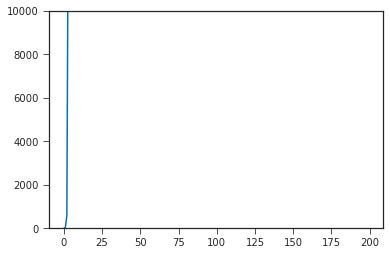

In [81]:
plt.plot(T_long[:, 0, 0])
plt.ylim([0, 10000])

In [210]:
# save every 10th frame, or every 100 steps = 10 ns
np.save("../data/qMSM_T_10-10000_feat2.npy", T_long[::10])

###  test integrator

In [160]:
def test(t, y, c):
    return y - c

In [168]:
c = 1
pts = integrate_heun(test, 2, 0, 0.1, 10, c)

(1,)
1
1.105
1.221025
1.349232625
1.490902050625
1.6474467659406251
1.8204286763643909
2.011573687382652
2.2227889245578303
2.4561817616364023


<function matplotlib.pyplot.yscale(value, **kwargs)>

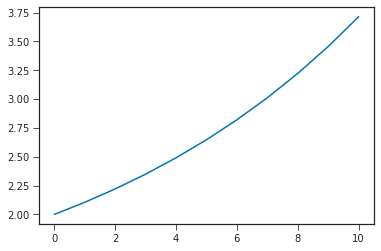

In [169]:
plt.plot(pts)
plt.yscale

#  Plots

In [71]:
# normalize transition matrices
T_mats = T_long[::10]

In [72]:
row_sums = T_mats.sum(axis=2, keepdims=True)
T_mats = T_mats / row_sums

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [73]:
row_sums[3]

array([[ 5.45696821e-12],
       [-8.29459168e-10],
       [-2.44472176e-08],
       [ 5.09317033e-11],
       [-1.22236088e-09],
       [-4.56348062e-08],
       [ 2.99769454e-09],
       [-9.09494702e-12],
       [-6.40284270e-10],
       [ 5.52972779e-10],
       [ 9.31322575e-10],
       [ 2.38069333e-08],
       [-4.91127139e-11],
       [ 1.07684173e-09],
       [-5.67524694e-10],
       [-5.58793545e-09],
       [-5.45696821e-11],
       [ 2.32830644e-10],
       [-7.33416528e-09],
       [-6.98491931e-10],
       [ 2.32830644e-10],
       [ 8.94069672e-07],
       [-5.00585884e-09],
       [-5.31144906e-10],
       [-3.16504156e-10],
       [-7.27595761e-12],
       [ 6.98491931e-10],
       [ 5.47152013e-09],
       [-1.60071068e-09],
       [-4.36557457e-11],
       [-9.45874490e-11],
       [-1.74622983e-10],
       [-5.82076609e-11],
       [-1.09139364e-11],
       [ 1.81607902e-08],
       [ 4.94765118e-09],
       [-3.49245965e-10],
       [ 4.98403097e-10],
       [-2.0